# Lyrics scrapper from genius API 

This script scrapes the lyrics of the songs given the years and url-tags for the songs featured in the year-end list on billboard. For instance, the inputs we need are 

1) Year

2) urltag (eg. hot-100). 

To verify that the url is valid, we can go to the following url:   https://www.billboard.com/charts/year-end" "/" + str(year) + '/' + chart['urltag'])

In [ ]:
import requests
from bs4 import BeautifulSoup as bs
import json
from IPython.display import clear_output
import numpy as np
import pandas as pd
import re
import lyricsgenius as genius
#total[0]
import time

def getLyric(song, artist):
        '''return lyrics for a single song or None if not found'''
        try:
            return geniusAPI.search_song(song, artist).lyrics
    
        except:
            #if there was an error then the lyrics weren't found so return None
            return

In [2]:
def getChartEntries(url):
        '''
        Returns a list of dictionaries with the rank, title and artist of each song 
        from the chart on the passed url page
        '''

        r = requests.get(url)
        soup = bs(r.content, "lxml")
        chartEntries = soup.find_all("div", attrs={"class":"ye-chart-item__primary-row"})

        chart = []
        for entry in chartEntries:
            chart.append({'rank': int(entry.find("div", attrs={"class":"ye-chart-item__rank"}).text),
                          'song': entry.find("div", attrs={"class":"ye-chart-item__title"}).text.strip(),

                          #replacing 'x' and 'X' with '&' as that's how genius.com has the names
                          #need to match so the lyrics be looked up later
                          'artist': entry.find("div", 
                                               attrs={"class":"ye-chart-item__artist"}).text.strip()\
                                                  .replace(' x ', ' & ').replace(' X ', ' & ')})

        return chart

In [3]:
# client_id, secret and access token from genius API 
client_id = 'vrYEyXFYI-_IPZ2SSx1khJAKyqk0WvbNXIK8Fe7sX7YK2RK8MDV3DCiges6RG9Go'
client_secret = 'vSP6B_lTYNKrlD8jXGY3l6kerEq6JTaQKT2tpb1K1M1iUjmvmBA5FXhObnJv88KsTEsG9jTINkfPG7VM_69J0Q'
client_access_token = 'FO5Ds2SyBUI_1PloUUQ-CC7E-liQz3HFspAWEVNKgoot88NIWSBd02cln7UGVO_F'

In [4]:
geniusAPI = genius.Genius(client_access_token)


#different charts go back differing amounts of years
#They all go back to 2013 or without dance/elec they go back to at least 2006
start_year = 2006
end_year = 2007
years = [i for i in range(start_year, end_year+1)]
print(years)

[2006, 2007]


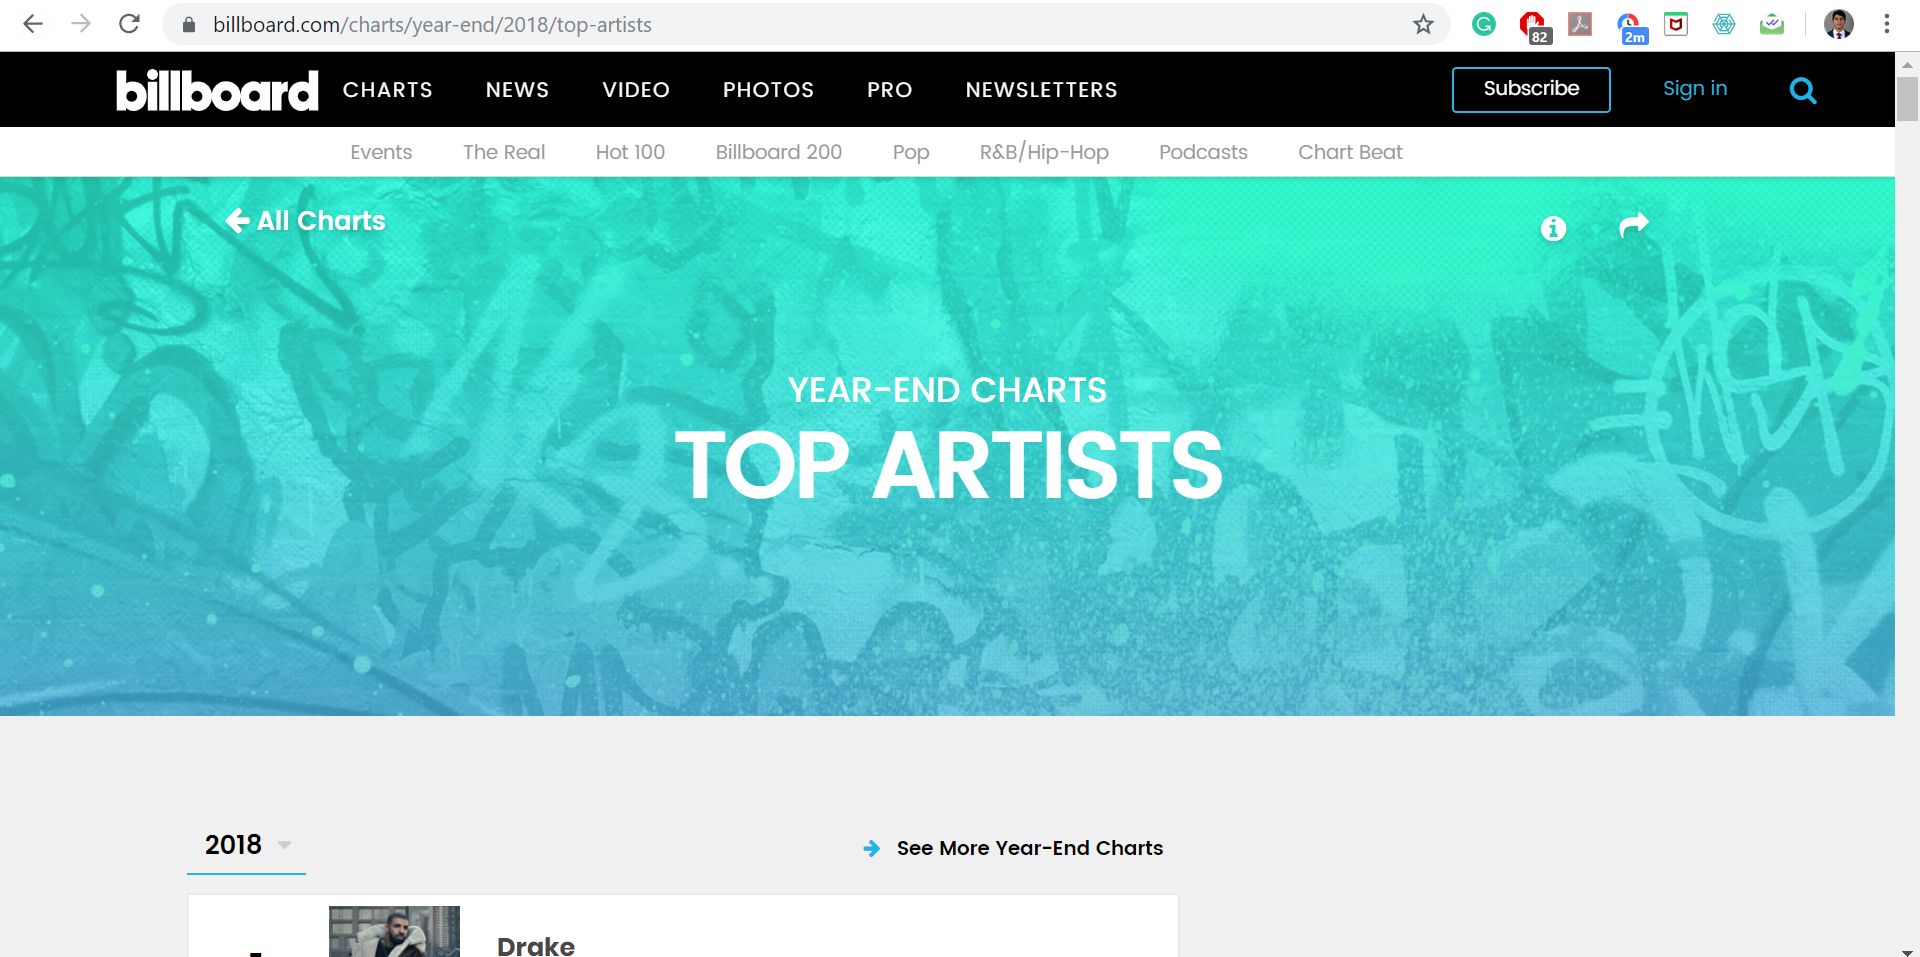

In [5]:
charts = pd.read_csv('tags.csv')
charts = charts.to_dict(orient='records')
charts

[{'name': 'Hot100', 'urltag': 'hot-100-songs'}]

In [6]:
total = []
for chart in charts: 
    for year in years:
        chart['url'] = ("https://www.billboard.com/charts/year-end" + 
                        "/" + str(year) + '/' + chart['urltag'])
        chart['entries'] = getChartEntries(chart['url'])
        total.append(chart.copy())

In [ ]:
def get_year(url):
    '''Function to get year, given an url in the billboard format '''
     return int(re.findall('(\d{4})', url)[0])
    
main_df = pd.DataFrame(columns=['name','urltag','url', 'artist','lyrics','rank','song',])
for chart in total:
    i = 0
    for song in chart['entries']:
        i+=1
        clear_output()
        print('Year: ', i) 
        print('Chart: ', chart['name']) 
        print('Getting song', i, ':', song['song'])

        #try getting lyrics with name as is
        song['lyrics'] = getLyric(song['song'], song['artist'])

        #if lyrics not found it's normally because of the featuring artists
        #try splitting on different ways songs add featuring artists to the end of artist names
        #sometimes a combination is used so trying each individually
        artistSplits = ['Featuring', 'With', 'And', '&', '/', ',']
        for splitter in artistSplits:
            #if lyrics have been found they'll be a non-empty string which evaluates as true
            if song['lyrics']:
                break

            song['lyrics'] = getLyric(song['song'], 
                                      song['artist'].split(splitter)[0].strip())

        if not song['lyrics']:
            song['lyrics'] = getLyric(song['song'].split('(')[0].strip(), 
                                      song['artist'])
    t2 = pd.DataFrame(chart['entries'])
    t1 = pd.DataFrame(chart)[['name','urltag', 'url']]
    
    main_df = main_df.append(pd.concat([t1, t2], axis=1))
    main_df['year'] = main_df['url'].apply(get_year)
    name = 'main_df' + str(time.time()) + '.csv'
    main_df.to_csv(name, index = False)

Year:  31
Chart:  Hot100
Getting song 31 : Beautiful Girls
Searching for "Beautiful Girls" by Sean Kingston...
